Table: Matches

* Match_ID (int): unique ID per match
* Div (str): identifies the division the match was played in (D1 = Bundesliga, D2 = Bundesliga 2, E0 = English Premier League)
* Season (int): Season the match took place in (usually covering the period of August till May of the following year)
* Date (str): Date of the match
* HomeTeam (str): Name of the home team
* AwayTeam (str): Name of the away team
* FTHG (int) (Full Time Home Goals): Number of goals scored by the home team
* FTAG (int) (Full Time Away Goals): Number of goals scored by the away team
* FTR (str) (Full Time Result): 3-way result of the match (H = Home Win, D = Draw, A = Away Win)

Table: Teams

* Season (str): Football season for which the data is valid
* TeamName (str): Name of the team the data concerns
* KaderHome (str): Number of Players in the squad
* AvgAgeHome (str): Average age of players
* ForeignPlayersHome (str): Number of foreign players (non-German, non-English respectively) playing for the team
* OverallMarketValueHome (str): Overall market value of the team pre-season in EUR (based on data from transfermarkt.de)
* AvgMarketValueHome (str): Average market value (per player) of the team pre-season in EUR (based on data from transfermarkt.de)
* StadiumCapacity (str): Maximum stadium capacity of the team's home stadium

Table: Unique Teams

* TeamName (str): Name of a team
* Unique_Team_ID (int): Unique identifier for each team

Table: Teams_in_Matches

* Match_ID (int): Unique match ID
* Unique_Team_ID (int): Unique team ID (This table is used to easily retrieve each match a given team has played in)

In [143]:
# Import libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import numpy as np
import requests
import json
import requests
import pymongo

In [2]:
# OOP
class SQL:
    def __init__(self, database):
        self.database = database
        conn = sqlite3.connect(database)
        self.cur = conn.cursor()
    
    def read_sql(self, query):
        df = pd.DataFrame(self.cur.execute(query).fetchall())
        df.columns = [x[0] for x in self.cur.description]
        self.df = df
        return df
pass

In [3]:
database = 'database.sqlite'
df_setup = SQL(database)

In [4]:
# Example Query
query = '''SELECT * 
            from Matches 
            WHERE Season = 2011 AND Div != "E0" '''

df_query = df_setup.read_sql(query)
df_query.tail()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
607,1699,D2,2011,2011-07-24,Paderborn,Fortuna Dusseldorf,1,1,D
608,1700,D2,2011,2011-12-10,Bochum,Fortuna Dusseldorf,1,1,D
609,1701,D2,2011,2011-08-15,Ein Frankfurt,Fortuna Dusseldorf,1,1,D
610,1702,D2,2011,2011-08-27,Aachen,Fortuna Dusseldorf,0,0,D
611,1703,D2,2011,2011-09-16,Erzgebirge Aue,Fortuna Dusseldorf,2,4,A


In [5]:
# Home Stats Query
home_query = '''SELECT HomeTeam,
            COUNT (HomeTeam) * 2 AS Games_Played,
            SUM(FTHG) AS Home_Goals,
            SUM(FTAG) AS Goals_Conceded,
            COUNT(CASE WHEN FTR = 'H' THEN 1 ELSE NULL END) AS Home_Wins,
            COUNT(CASE WHEN FTR = 'D' THEN 1 ELSE NULL END) AS Home_Draw
            FROM Matches
            WHERE Season = '2011' AND Div != "E0"
            GROUP BY 1'''

home_query = df_setup.read_sql(home_query)
home_query.head()

,HomeTeam,Games_Played,Home_Goals,Goals_Conceded,Home_Wins,Home_Draw
0,Aachen,34,15,24,4,6
1,Augsburg,34,20,19,6,7
2,Bayern Munich,34,49,6,14,1
3,Bochum,34,23,23,7,3
4,Braunschweig,34,21,15,6,8


In [6]:
# Away Stats Query
away_query = '''SELECT AwayTeam,
        SUM(FTAG) AS Away_Goals,
        SUM(FTHG) AS Goals_Conceded,
        COUNT(CASE WHEN FTR = 'A' THEN 1 ELSE NULL END) AS Away_Wins,
        COUNT(CASE WHEN FTR = 'D' THEN 1 ELSE NULL END) AS Away_Draw
        FROM Matches
        WHERE Season = '2011' AND Div != "E0"
        GROUP BY 1'''

away_query = df_setup.read_sql(away_query)
away_query.head()

,AwayTeam,Away_Goals,Goals_Conceded,Away_Wins,Away_Draw
0,Aachen,15,23,2,7
1,Augsburg,16,30,2,7
2,Bayern Munich,28,16,9,3
3,Bochum,18,32,3,4
4,Braunschweig,16,20,4,7


In [45]:
combined_query = '''
            SELECT h.HomeTeam AS Team,
            h.Games_Played AS Games_Played,
            SUM(h.Home_Goals + a.Away_Goals) AS Goals_Scored,
            SUM(h.Goals_Conceded + a.Goals_Conceded) AS Goals_Conceded,
            SUM(h.Home_Wins + a.Away_Wins) AS Total_Wins,
            SUM(h.Home_Draws + a.Away_Draws) AS Total_Draws,
            SUM(h.Games_Played - h.Home_Wins - a.Away_Wins - h.Home_Draws - a.Away_Draws) AS Total_Losses,
            SUM((h.Home_Wins + a.Away_Wins) * 100 / h.Games_Played) AS Win_Percentage   
            
            FROM

            (SELECT HomeTeam, 
            COUNT (HomeTeam) * 2 AS Games_Played,
            SUM(FTHG) AS Home_Goals, 
            SUM(FTAG) AS Goals_Conceded,
            COUNT(CASE WHEN FTR = 'H' THEN 1 ELSE NULL END) AS Home_Wins,
            COUNT(CASE WHEN FTR = 'D' THEN 1 ELSE NULL END) AS Home_Draws
            FROM Matches
            WHERE Season = '2011' AND Div != "E0"
            GROUP BY 1) h
            
            LEFT JOIN
            
            (SELECT AwayTeam,
            SUM(FTAG) AS Away_Goals,
            SUM(FTHG) AS Goals_Conceded,
            COUNT(CASE WHEN FTR = 'A' THEN 1 ELSE NULL END) AS Away_Wins,
            COUNT(CASE WHEN FTR = 'D' THEN 1 ELSE NULL END) AS Away_Draws
            FROM Matches
            WHERE Season = '2011' AND Div != "E0"
            GROUP BY 1) a

            ON h.HomeTeam = a.AwayTeam
            GROUP BY 1
            ORDER BY Win_Percentage DESC
'''

combined_query = df_setup.read_sql(combined_query)
updated_df = combined_query
updated_df.head()

,Team,Games_Played,Goals_Scored,Goals_Conceded,Total_Wins,Total_Draws,Total_Losses,Win_Percentage
0,Dortmund,34,80,25,25,6,3,73
1,Bayern Munich,34,77,22,23,4,7,67
2,Schalke 04,34,74,44,20,4,10,58
3,Greuther Furth,34,73,27,20,10,4,58
4,Ein Frankfurt,34,76,33,20,8,6,58


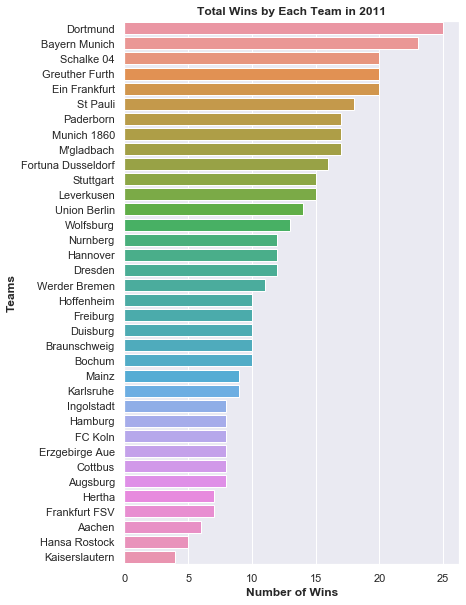

In [160]:
fig_dims = (6, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(style="darkgrid")
ax = sns.barplot(x="Total_Wins", y="Team", data=updated_df)
plt.ylabel('Teams', fontweight='bold')
plt.xlabel('Number of Wins', fontweight='bold')
plt.title('Total Wins by Each Team in 2011', fontweight = 'bold')
plt.savefig('Wins by Each Team.jpeg', dpi=300, bbox_inches = "tight")

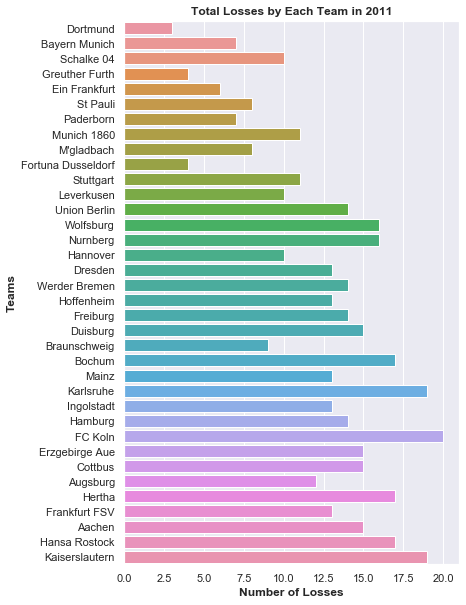

In [161]:
fig_dims = (6, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set(style="darkgrid")
ax = sns.barplot(x="Total_Losses", y="Team", data=updated_df)
plt.ylabel('Teams', fontweight='bold')
plt.xlabel('Number of Losses', fontweight='bold')
plt.title('Total Losses by Each Team in 2011', fontweight = 'bold')
plt.savefig('Losses by Each Team.jpeg', dpi=300, bbox_inches = "tight")

In [9]:
rain_query = '''SELECT * 
            from Matches 
            WHERE Season = 2011 AND Div != "E0"
            ORDER BY Date'''

df_query = df_setup.read_sql(rain_query)
rain_df = df_query
rain_df.Date = rain_df.Date.apply(lambda x: x + 'T17:00:00')
rain_df

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1133,D2,2011,2011-07-15T17:00:00,Cottbus,Dresden,2,1,H
1,1167,D2,2011,2011-07-15T17:00:00,Greuther Furth,Ein Frankfurt,2,3,A
2,1551,D2,2011,2011-07-15T17:00:00,Frankfurt FSV,Union Berlin,1,1,D
3,1550,D2,2011,2011-07-16T17:00:00,Erzgebirge Aue,Aachen,1,0,H
4,1678,D2,2011,2011-07-16T17:00:00,St Pauli,Ingolstadt,2,0,H
...,...,...,...,...,...,...,...,...,...
607,1528,D2,2011,2012-05-06T17:00:00,Hansa Rostock,Greuther Furth,2,2,D
608,1540,D2,2011,2012-05-06T17:00:00,Munich 1860,Aachen,1,2,A
609,1552,D2,2011,2012-05-06T17:00:00,Cottbus,Union Berlin,2,1,H
610,1610,D2,2011,2012-05-06T17:00:00,St Pauli,Paderborn,5,0,H


In [10]:
rain_df.Date.unique()

array(['2011-07-15T17:00:00', '2011-07-16T17:00:00',
       '2011-07-17T17:00:00', '2011-07-18T17:00:00',
       '2011-07-22T17:00:00', '2011-07-23T17:00:00',
       '2011-07-24T17:00:00', '2011-07-25T17:00:00',
       '2011-08-05T17:00:00', '2011-08-06T17:00:00',
       '2011-08-07T17:00:00', '2011-08-08T17:00:00',
       '2011-08-12T17:00:00', '2011-08-13T17:00:00',
       '2011-08-14T17:00:00', '2011-08-15T17:00:00',
       '2011-08-19T17:00:00', '2011-08-20T17:00:00',
       '2011-08-21T17:00:00', '2011-08-22T17:00:00',
       '2011-08-26T17:00:00', '2011-08-27T17:00:00',
       '2011-08-28T17:00:00', '2011-08-29T17:00:00',
       '2011-09-09T17:00:00', '2011-09-10T17:00:00',
       '2011-09-11T17:00:00', '2011-09-12T17:00:00',
       '2011-09-16T17:00:00', '2011-09-17T17:00:00',
       '2011-09-18T17:00:00', '2011-09-19T17:00:00',
       '2011-09-23T17:00:00', '2011-09-24T17:00:00',
       '2011-09-25T17:00:00', '2011-09-26T17:00:00',
       '2011-09-30T17:00:00', '2011-10-01T17:0

In [11]:
def get_keys(path):
    with open(path) as f:
        return json.load(f)

In [12]:
keys = get_keys("/Users/songying7/Desktop/module_2_project/delphi_football/.secret/darksky_api.json")

api_key = keys['api_key']

In [13]:
date_weather = {}
for date in rain_df.Date.unique():
    url = f"https://api.darksky.net/forecast/{api_key}/52.5200,13.4050,{date}"
    response = requests.get(url)
    weather = response.json()['daily']['data'][0].get('icon', 0)
    date_weather.update({date: weather})

In [14]:
date_weather

{'2011-07-15T17:00:00': 'partly-cloudy-day',
 '2011-07-16T17:00:00': 0,
 '2011-07-17T17:00:00': 'rain',
 '2011-07-18T17:00:00': 'rain',
 '2011-07-22T17:00:00': 'rain',
 '2011-07-23T17:00:00': 'rain',
 '2011-07-24T17:00:00': 'partly-cloudy-day',
 '2011-07-25T17:00:00': 'partly-cloudy-day',
 '2011-08-05T17:00:00': 'rain',
 '2011-08-06T17:00:00': 'rain',
 '2011-08-07T17:00:00': 'rain',
 '2011-08-08T17:00:00': 'rain',
 '2011-08-12T17:00:00': 'rain',
 '2011-08-13T17:00:00': 'partly-cloudy-day',
 '2011-08-14T17:00:00': 'rain',
 '2011-08-15T17:00:00': 'rain',
 '2011-08-19T17:00:00': 'partly-cloudy-day',
 '2011-08-20T17:00:00': 0,
 '2011-08-21T17:00:00': 0,
 '2011-08-22T17:00:00': 'partly-cloudy-day',
 '2011-08-26T17:00:00': 0,
 '2011-08-27T17:00:00': 'partly-cloudy-day',
 '2011-08-28T17:00:00': 'partly-cloudy-day',
 '2011-08-29T17:00:00': 'partly-cloudy-day',
 '2011-09-09T17:00:00': 'partly-cloudy-day',
 '2011-09-10T17:00:00': 'partly-cloudy-day',
 '2011-09-11T17:00:00': 'rain',
 '2011-09-12T

In [15]:
rain_df

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1133,D2,2011,2011-07-15T17:00:00,Cottbus,Dresden,2,1,H
1,1167,D2,2011,2011-07-15T17:00:00,Greuther Furth,Ein Frankfurt,2,3,A
2,1551,D2,2011,2011-07-15T17:00:00,Frankfurt FSV,Union Berlin,1,1,D
3,1550,D2,2011,2011-07-16T17:00:00,Erzgebirge Aue,Aachen,1,0,H
4,1678,D2,2011,2011-07-16T17:00:00,St Pauli,Ingolstadt,2,0,H
...,...,...,...,...,...,...,...,...,...
607,1528,D2,2011,2012-05-06T17:00:00,Hansa Rostock,Greuther Furth,2,2,D
608,1540,D2,2011,2012-05-06T17:00:00,Munich 1860,Aachen,1,2,A
609,1552,D2,2011,2012-05-06T17:00:00,Cottbus,Union Berlin,2,1,H
610,1610,D2,2011,2012-05-06T17:00:00,St Pauli,Paderborn,5,0,H


In [16]:
rain_df['Weather'] = rain_df['Date'].map(date_weather)

In [17]:
choice = sorted(rain_df[rain_df.Weather != 0]['Weather'].unique())
prob = rain_df[rain_df.Weather != 0]['Weather'].value_counts(normalize=True).sort_index()
rain_df['Weather'] = rain_df.Weather.map(lambda x: np.random.choice(choice, 1, p= prob)[0] if x == 0 else x)

In [18]:
for weather in rain_df.Weather:
    if weather == 'rain':
        rain_df.Weather.replace(to_replace = weather, value = 1, inplace=True)
    elif weather == 'partly-cloudy-day':
        rain_df.Weather.replace(to_replace = weather, value = 0, inplace=True)
    elif weather == 'cloudy':
        rain_df.Weather.replace(to_replace = weather, value = 0, inplace=True)
    elif weather == 'wind':
        rain_df.Weather.replace(to_replace = weather, value = 0, inplace=True)
    elif weather == 'clear-day':
        rain_df.Weather.replace(to_replace = weather, value = 0, inplace=True)

In [19]:
rain_df.Weather.value_counts()

0    409
1    203
Name: Weather, dtype: int64

In [20]:
rain_df

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Weather
0,1133,D2,2011,2011-07-15T17:00:00,Cottbus,Dresden,2,1,H,0
1,1167,D2,2011,2011-07-15T17:00:00,Greuther Furth,Ein Frankfurt,2,3,A,0
2,1551,D2,2011,2011-07-15T17:00:00,Frankfurt FSV,Union Berlin,1,1,D,0
3,1550,D2,2011,2011-07-16T17:00:00,Erzgebirge Aue,Aachen,1,0,H,0
4,1678,D2,2011,2011-07-16T17:00:00,St Pauli,Ingolstadt,2,0,H,1
...,...,...,...,...,...,...,...,...,...,...
607,1528,D2,2011,2012-05-06T17:00:00,Hansa Rostock,Greuther Furth,2,2,D,1
608,1540,D2,2011,2012-05-06T17:00:00,Munich 1860,Aachen,1,2,A,1
609,1552,D2,2011,2012-05-06T17:00:00,Cottbus,Union Berlin,2,1,H,1
610,1610,D2,2011,2012-05-06T17:00:00,St Pauli,Paderborn,5,0,H,1


In [21]:
rain_matches = rain_df[rain_df.Weather == 1]
rain_matches

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Weather
4,1678,D2,2011,2011-07-16T17:00:00,St Pauli,Ingolstadt,2,0,H,1
5,1146,D2,2011,2011-07-17T17:00:00,Karlsruhe,Duisburg,3,2,H,1
6,1442,D2,2011,2011-07-17T17:00:00,Braunschweig,Munich 1860,3,1,H,1
7,1602,D2,2011,2011-07-17T17:00:00,Hansa Rostock,Paderborn,1,2,A,1
8,1360,D2,2011,2011-07-18T17:00:00,Fortuna Dusseldorf,Bochum,2,0,H,1
...,...,...,...,...,...,...,...,...,...,...
607,1528,D2,2011,2012-05-06T17:00:00,Hansa Rostock,Greuther Furth,2,2,D,1
608,1540,D2,2011,2012-05-06T17:00:00,Munich 1860,Aachen,1,2,A,1
609,1552,D2,2011,2012-05-06T17:00:00,Cottbus,Union Berlin,2,1,H,1
610,1610,D2,2011,2012-05-06T17:00:00,St Pauli,Paderborn,5,0,H,1


In [149]:
# Count Win/Draw/Loss
HomeWin = rain_matches.groupby('HomeTeam')['FTR'].apply(lambda x: x[x =='H'].count())
AwayWin = rain_matches.groupby('HomeTeam')['FTR'].apply(lambda x: x[x =='A'].count())
HomeDraw = rain_matches.groupby('HomeTeam')['FTR'].apply(lambda x: x[x =='D'].count())
AwayDraw = rain_matches.groupby('HomeTeam')['FTR'].apply(lambda x: x[x =='D'].count())
HomeLoss = rain_matches.groupby('HomeTeam')['FTR'].apply(lambda x: x[x =='A'].count())
AwayLoss = rain_matches.groupby('HomeTeam')['FTR'].apply(lambda x: x[x =='H'].count())

# Summarize
TotalWin = HomeWin + AwayWin
TotalDraw = HomeDraw + AwayDraw
TotalLoss = HomeLoss + AwayLoss
TotalGames = TotalWin + TotalDraw + TotalLoss
Rain_Win_Percentage = round(TotalWin * 100 / TotalGames, 2 )

# Place in a pandas dataframe
RainStats = pd.concat([TotalWin, TotalDraw, TotalLoss, TotalGames, Rain_Win_Percentage], axis = 1) 

# Define column names
RainStats.columns = ['TotalWin', 'TotalDraw', 'TotalLoss', 'TotalGames', 'Rain_Win_Percentage']

In [150]:
RainStats

,TotalWin,TotalDraw,TotalLoss,TotalGames,Rain_Win_Percentage
HomeTeam,,,,,
Aachen,0,4,0,4,0.00
Augsburg,3,2,3,8,37.50
Bayern Munich,5,2,5,12,41.67
Bochum,3,0,3,6,50.00
Braunschweig,4,6,4,14,28.57
Cottbus,3,2,3,8,37.50
Dortmund,4,0,4,8,50.00
Dresden,5,2,5,12,41.67
Duisburg,3,2,3,8,37.50


In [151]:
RainStats_Short = pd.concat([Rain_Win_Percentage], axis = 1) 
RainStats_Short.columns = ['Rain_Win_Percentage']
RainStats_Short.reset_index(inplace = True)
RainStats_Short.rename(columns={"HomeTeam": "Team"}, inplace = True)
RainStats_Short

,Team,Rain_Win_Percentage
0,Aachen,0.00
1,Augsburg,37.50
2,Bayern Munich,41.67
3,Bochum,50.00
4,Braunschweig,28.57
5,Cottbus,37.50
6,Dortmund,50.00
7,Dresden,41.67
8,Duisburg,37.50
9,Ein Frankfurt,33.33


In [152]:
final_df = pd.merge(updated_df,RainStats_Short, on = "Team")

In [153]:
final_df

,Team,Games_Played,Goals_Scored,Goals_Conceded,Total_Wins,Total_Draws,Total_Losses,Win_Percentage,Rain_Win_Percentage
0,Dortmund,34,80,25,25,6,3,73,50.00
1,Bayern Munich,34,77,22,23,4,7,67,41.67
2,Schalke 04,34,74,44,20,4,10,58,50.00
3,Greuther Furth,34,73,27,20,10,4,58,50.00
4,Ein Frankfurt,34,76,33,20,8,6,58,33.33
5,St Pauli,34,59,34,18,8,8,52,50.00
6,Paderborn,34,51,42,17,10,7,50,25.00
7,Munich 1860,34,62,46,17,6,11,50,44.44
8,M'gladbach,34,49,24,17,9,8,50,28.57
9,Fortuna Dusseldorf,34,64,35,16,14,4,47,28.57


In [154]:
class MongoDB():
    def __init__(self, database_name):
        myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
        self.myclient = myclient
        self.database_name = database_name
        mydb = myclient[self.database_name]
        self.mydb = mydb
    
    def df_to_dict(self, df):
        df_dict = df.to_dict(orient = 'records')
        self.df_dict = df_dict
        return df_dict
    
    def addCollection(self, collection_name):
        mycollection = self.mydb[collection_name]
        results = mycollection.insert_many(self.df_dict)
        self.collection_name = collection_name
        self.collection = mycollection
        return mycollection
    
    def db_list(self):
        return self.myclient.list_database_names()
    
    def collection_list(self):
        return self.mydb.list_collection_names()
    
    def drop_database(self):
        self.myclient.drop_database(self.database_name)
        return '{} database dropped'.format(self.database_name)
    
    def del_collection(self):
        self.mydb.drop_collection(self.collection_name)     
        return '{} collection dropped'.format(self.collection_name)
        
    def print_records(self):
        query  = self.collection.find({})
        for record in query:
            print (record)

In [156]:
delphi_football = MongoDB('delphi_football')
delphi_football.df_to_dict(final_df)
delphi_football.addCollection('delphi_football')

Collection(Database(MongoClient(host=['127.0.0.1:27017'], document_class=dict, tz_aware=False, connect=True), 'delphi_football'), 'delphi_football')

In [157]:
myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
mydb = myclient['delphi_football']
mydb.list_collection_names()

['delphi_football']